In [11]:
import pandas_datareader as data
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import yfinance as yf
from tensorflow import keras
%matplotlib inline

**Make larger inputs (intra-day)**

In [2]:
intraday_data = yf.download(tickers="MSFT",
                            period="2y",
                            interval="1h",
                            auto_adjust=True)
intraday_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
2020-05-14 09:30:00-04:00,177.539993,178.889999,175.735703,175.789993,8841683
2020-05-14 10:30:00-04:00,175.800003,177.940002,175.679993,177.260101,6053059
2020-05-14 11:30:00-04:00,177.279999,178.169998,176.000000,176.830093,4640860
2020-05-14 12:30:00-04:00,176.860001,178.154999,176.449997,178.109894,3232095
2020-05-14 13:30:00-04:00,178.100006,178.320007,177.190002,178.219696,2931715


In [3]:
intraday_data.axes[0][0]

Timestamp('2020-05-14 09:30:00-0400', tz='America/New_York')

In [4]:
sequence_opens = intraday_data.values[: , 0]

In [5]:
sequence_opens.shape

(3526,)

In [6]:
pd.options.plotting.backend = "plotly"
intraday_data.plot(y=['Open'])

**Split and flip data randomly**

In [7]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [8]:
# choose a number of time steps
n_steps = 64
# split into samples
X, y = split_sequence(sequence_opens, n_steps)

In [9]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

In [13]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(3462, 64, 1)

**Wavenet**

In [14]:
model = keras.Sequential()
# 10 000
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mae')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 63, 64)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 31, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1984)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                99250     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 99,493
Trainable params: 99,493
Non-trainable params: 0
_________________________________________________________________


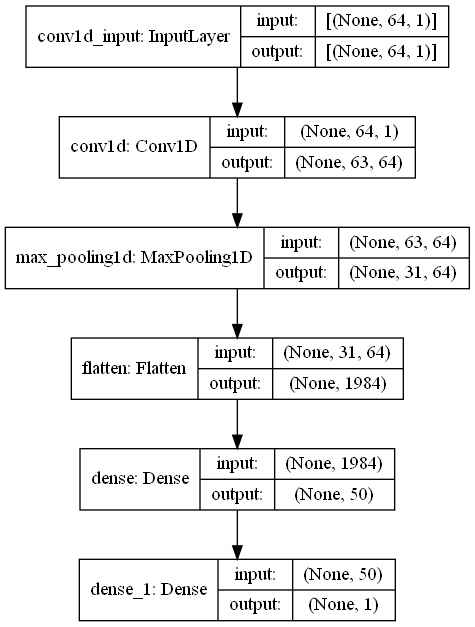

In [15]:
import tensorflow as tf
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

**Test and train evaluation**

**Scatter plots (correlation)**